In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
import readdata
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det
import os.path
from scipy import misc
import cv2
from progress_bar import ProgressBar
import shapefeatures
from sklearn import ensemble

Populating the interactive namespace from numpy and matplotlib


/home/anson/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
opts = {'img_dir': '/media/anson/Windows/ANSON_CEN16002_MAIN_PJT/data/images_TB/',
        'annotation_dir': '/media/anson/Windows/ANSON_CEN16002_MAIN_PJT/data/annotation_TB/',
        'detection_probability_threshold': 0.5,
        'detection_overlap_threshold': 0.3, 
        'gauss': 1,
        'patch_size': (160,160),
        'image_downsample' : 8,
        'detection_step': 5,
        'patch_creation_step': 40,
        'object_class': None,
        'negative_training_discard_rate': .9
       }
opts['patch_stride_training'] = int(opts['patch_size'][0]*.25)

In [11]:
patch_size= (160,160)

In [12]:
patch_size

(160, 160)

In [13]:
reload(readdata)

<module 'readdata' from 'readdata.pyc'>

In [14]:
trainfiles, valfiles, testfiles = readdata.create_sets(opts['img_dir'], train_set_proportion=.5, 
                                                  test_set_proportion=.5,
                                                  val_set_proportion=0)

train_y, train_X = readdata.create_patches(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])
test_y, test_X = readdata.create_patches(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['patch_size'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'], objectclass=opts['object_class'], negative_discard_rate=opts['negative_training_discard_rate'])

# Cut down on disproportionately large numbers of negative patches
train_X, train_y = readdata.balance(train_X, train_y, mult_neg=100)
test_X, test_y = readdata.balance(test_X, test_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = readdata.augment_positives(train_X, train_y)
test_X, test_y = readdata.augment_positives(test_X, test_y)

print '\n'
print '%d positive training examples, %d negative training examples' % (sum(train_y), len(train_y)-sum(train_y))
print '%d positive testing examples, %d negative testing examples' % (sum(test_y), len(test_y)-sum(test_y))
print '%d patches (%.1f%% positive)' % (len(train_y)+len(test_y), 100.*((sum(train_y)+sum(test_y))/(len(train_y)+len(test_y))))

[****************100%******************]  633 of 633 complete                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

View a random selection of positive and negative patches to see if they look right

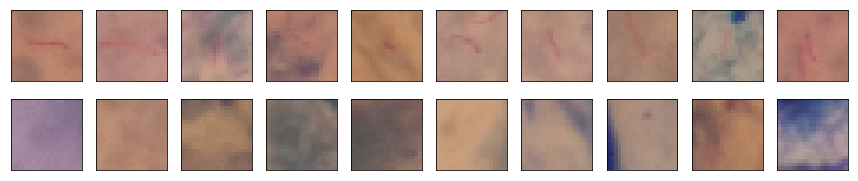

In [23]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)
#plt.savefig('GRU_TB_FIN/Randon_pos-neg.png', bbox_inches='tight')

### CNN training

In [16]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('RNN',layers.RecurrentLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
    RNN_num_units=10,    
        
        
    #conv2_num_filters=12, 
    #conv2_filter_size=(2, 2),    
    #conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    #hidden3_num_units=100,
        
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(500).fit(train_X, train_y)

# Neural Network with 1258 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   3x20x20
  1  conv1   7x18x18
  2  pool1   7x9x9
  3  RNN     7x10
  4  output  2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     0.60667     0.43846    1.38363      0.84582  6.46s
      2     0.35056     0.30146    1.16288      0.90434  6.36s
      3     0.28962     0.27030    1.07149      0.91106  6.77s
      4     0.26272     0.23769    1.10528      0.92316  6.92s
      5     0.23905     0.22248    1.07447      0.92767  7.01s
      6     0.22583     0.21492    1.05075      0.93039  6.89s
      7     0.21877     0.21239    1.03007      0.93001  6.90s
      8     0.21475     0.21033    1.02102      0.93058  7.04s
      9     0.21230     0.20956    1.01306      0.93090  6.94s
     10     0.21050     0.20820    1.01105      0.93179  6.89s
     11     0.20913     0.20789    1.0059

In [24]:
import cPickle as pickle
sys.setrecursionlimit(10000) # you may need this if the network is large
with open("model_file_TB_new", 'wb') as f:
     pickle.dump(cnn , f, -1)

In [25]:
#with open("model_file_IP", 'wb') as f:
with open('model_file_TB_new', 'rb') as pickle_file:
    c=pickle.load(pickle_file)
y_p=c.predict_proba(test_X)

In [26]:
y_p

array([[  9.99452221e-01,   5.47778537e-04],
       [  9.98308170e-01,   1.69183025e-03],
       [  8.78397768e-04,   9.99121602e-01],
       ..., 
       [  5.37279460e-03,   9.94627205e-01],
       [  9.99582622e-01,   4.17377963e-04],
       [  5.46916653e-03,   9.94530833e-01]])

In [12]:
#not needed
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['patch_size'][0]/opts['image_downsample'], 
                 opts['patch_size'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=100,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(500).fit(train_X, train_y)

# Neural Network with 77646 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    3x20x20
  1  conv1    7x18x18
  2  pool1    7x9x9
  3  conv2    12x8x8
  4  hidden3  100
  5  output   2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     0.74282     0.36836    2.01657      0.87173  8.95s
      2     0.33282     0.29663    1.12199      0.90546  8.92s
      3     0.29296     0.27886    1.05055      0.91091  9.73s
      4     0.27841     0.26891    1.03534      0.91358  9.52s
      5     0.26829     0.26153    1.02581      0.91573  10.05s
      6     0.26118     0.25728    1.01518      0.91630  9.59s
      7     0.25590     0.25346    1.00965      0.91763  9.34s
      8     0.25161     0.25020    1.00566      0.91877  9.64s
      9     0.24751     0.24720    1.00123      0.91973  9.57s
     10     0.24384     0.24420    0.99855      0.92042  8.74s
     11     

In [9]:
y_p

array([[ 0.00539772,  0.99460228],
       [ 0.0019269 ,  0.9980731 ],
       [ 0.99868276,  0.00131724],
       ..., 
       [ 0.99897708,  0.00102292],
       [ 0.98243619,  0.01756381],
       [ 0.99689061,  0.00310939]])

In [19]:
y_pred

array([[  9.99452221e-01,   5.47778537e-04],
       [  9.98308170e-01,   1.69183025e-03],
       [  8.78397768e-04,   9.99121602e-01],
       ..., 
       [  5.37279460e-03,   9.94627205e-01],
       [  9.99582622e-01,   4.17377963e-04],
       [  5.46916653e-03,   9.94530833e-01]])

### Make predictions and evaluate on test data

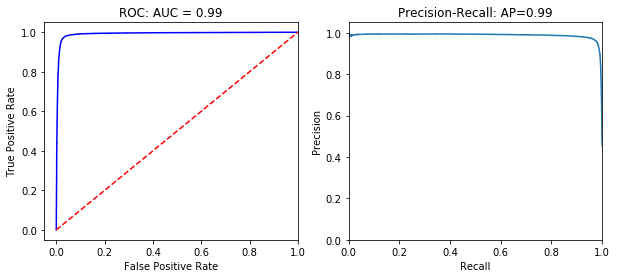

In [18]:
y_pred = cnn.predict_proba(test_X)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

#plt.savefig('GRU_TB_FIN/tuberculosis-patchevaluation_test.png', bbox_inches='tight')

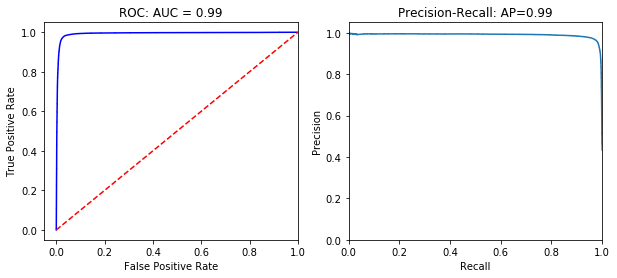

In [8]:
#NOT NEEDED
y_pred = cnn.predict_proba(train_X)

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(train_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

precision, recall, thresholds = metrics.precision_recall_curve(train_y, y_pred[:,1])
average_precision = metrics.average_precision_score(train_y, y_pred[:, 1])

subplot(121)
plt.title('ROC: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(122)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

plt.gcf().set_size_inches(10,4)

#plt.savefig('figs_TB/GRU/tuberculosis-patchevaluation_train.png', bbox_inches='tight')

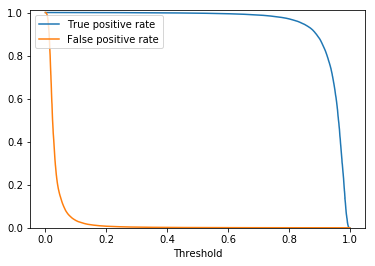

In [20]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
true_positive_rate.shape, thresholds.shape
plt.plot(true_positive_rate, thresholds,label='True positive rate')
plt.plot(false_positive_rate, thresholds, label='False positive rate')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(loc='upper left')
#plt.gcf().set_size_inches(5,5)

#plt.savefig('GRU_TB_FIN/tuberculosis-patchevaluation_TPR-FPR.png', bbox_inches='tight')

In [21]:
q=y_pred[:,1]>0.5
q=q*1
q

array([0, 0, 1, ..., 1, 0, 1])

In [22]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(test_y, q))
print 'The accuracy is:', accuracy_score(test_y, q)

             precision    recall  f1-score   support

          0       0.97      0.98      0.97     44541
          1       0.97      0.96      0.97     35344

avg / total       0.97      0.97      0.97     79885

The accuracy is: 0.970457532703


**Examine mistakes to understand network performance: false positives.** 

Find the negative-labelled patches with highest prediction score

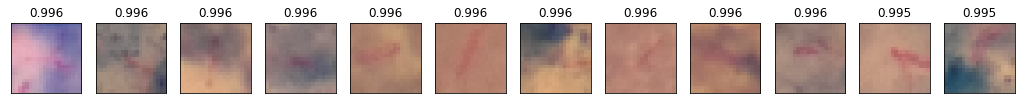

In [14]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]

N_samples_to_display = 12
offset = 55
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % neg_scores[i+offset])
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('GRU_TB_FIN/tuberculosis-falsedetections.png', bbox_inches='tight')

See highest-scored test patches

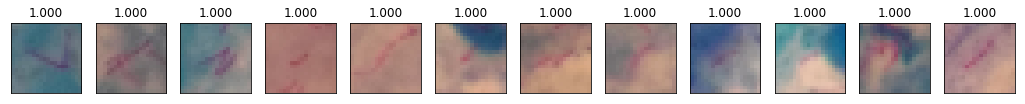

In [15]:
prob_range = [.95,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 12
offset = 0
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i+offset],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (tmp_scores[pos_indices[i+offset]]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('GRU_TB_FIN/tuberculosis-detectedpatches1.png', bbox_inches='tight')

See lowest scored test patches

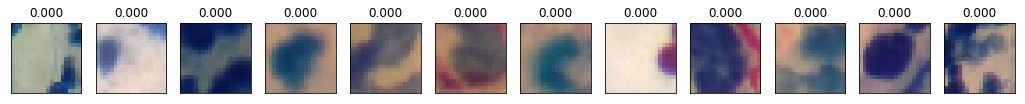

In [16]:
pos_indices = y_pred[:,1].argsort()

N_samples_to_display = 12

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg)
    plt.title('%.3f' % (y_pred[pos_indices[i],1]))
    plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')    

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

plt.savefig('GRU_TB_FIN/tuberculosis-testpatches-lowprob1.png', bbox_inches='tight')

### Example of objects detected in an entire image

The white boxes represent annotations in the training data. Red boxes are detections by the convnet.

In [17]:
reload(det)

<module 'detectobjects' from 'detectobjects.pyc'>

/home/anson/anaconda2/lib/python2.7/site-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


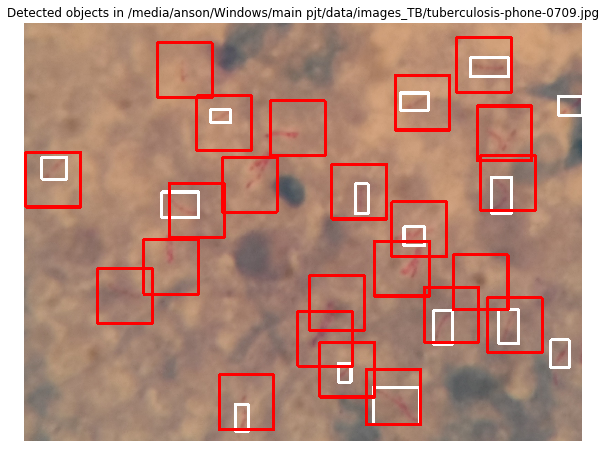

In [27]:


fname = testfiles[500]
imfile = opts['img_dir'] + fname
opts['detection_probability_threshold'] = 0.95
found = det.detect(imfile, cnn, opts)

im = misc.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

annofile = opts['annotation_dir'] + fname[:-3] + 'xml'
bboxes = readdata.get_bounding_boxes_for_single_image(annofile)
for bb in bboxes:
    bb = bb.astype(int)
    cv2.rectangle(im, (bb[0],bb[2]), (bb[1],bb[3]), (255,255,255), 8)  

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0],f[1]), (f[2],f[3]), (255,0,0), 8)

plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im)
plt.savefig('GRU_TB_FIN/tuberculosis-annotations500.png', bbox_inches='tight')
#cv2.imwrite('detectionimages/detected-' + os.path.ba5ename(imfile),im)

### Evaluation: compare with classification based on morphological feature extraction

In [52]:
featureset = [3,7,11,12,15,17]
centiles = [0,25,50,75,100]

pb = ProgressBar(train_X.shape[0])
train_X_f = []
for i in range(train_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(train_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    train_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
train_X_f = np.vstack(train_X_f)

test_X_f = []
for i in range(test_X.shape[0]):
    if i % 100 == 0:
        pb.step(i)
    graypatch = cv2.cvtColor(np.swapaxes(test_X[i,:,:,:],0,2).astype('uint8'), cv2.COLOR_BGR2GRAY)
    test_X_f.append(shapefeatures.extract(graypatch,attributes=featureset,centiles=centiles, momentfeatures=True))
test_X_f = np.vstack(test_X_f)

[                  0%                  ]

OSError: ./libshapefeatures.so: cannot open shared object file: No such file or directory

In [ ]:
clf = ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(train_X_f, train_y)
y_pred_CLF = clf.predict_proba(test_X_f)

In [ ]:
false_positive_rate_CNN, true_positive_rate_CNN, thresholds_CNN = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc_CNN = metrics.auc(false_positive_rate_CNN, true_positive_rate_CNN)

precision_CNN, recall_CNN, thresholds_CNN = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision_CNN = metrics.average_precision_score(test_y, y_pred[:, 1])

false_positive_rate_CLF, true_positive_rate_CLF, thresholds_CLF = metrics.roc_curve(test_y, y_pred_CLF[:,1])
roc_auc_CLF = metrics.auc(false_positive_rate_CLF, true_positive_rate_CLF)

precision_CLF, recall_CLF, thresholds_CLF = metrics.precision_recall_curve(test_y, y_pred_CLF[:,1])
average_precision_CLF = metrics.average_precision_score(test_y, y_pred_CLF[:, 1])

subplot(211)
plt.title('ROC' )
plt.plot(false_positive_rate_CNN, true_positive_rate_CNN, 'b', label='CNN: AUC=%.2f' % (roc_auc_CNN))
plt.plot(false_positive_rate_CLF, true_positive_rate_CLF, 'k--', label='ERT: AUC=%.2f' % (roc_auc_CLF))
plt.legend(loc='lower right')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

subplot(212)
plt.plot(recall_CNN, precision_CNN, label='CNN: AP=%.2f' % (average_precision_CNN))
plt.plot(recall_CLF, precision_CLF,'k--', label='ERT: AP=%.2f' % (average_precision_CLF))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="lower left")

plt.gcf().set_size_inches(4,10)

plt.savefig('figs/tuberculosis-patchevaluation.png', bbox_inches='tight')

In [ ]:
results = {
"false_positive_rate_CNN": false_positive_rate_CNN,
"true_positive_rate_CNN": true_positive_rate_CNN,
"false_positive_rate_CLF": false_positive_rate_CLF,
"true_positive_rate_CLF": true_positive_rate_CLF,
"roc_auc_CNN": roc_auc_CNN,
"roc_auc_CLF": roc_auc_CLF,
"recall_CNN": recall_CNN,
"precision_CNN": precision_CNN,
"average_precision_CNN": average_precision_CNN,
"recall_CLF": recall_CLF,
"precision_CLF": precision_CLF,
"average_precision_CLF": average_precision_CLF,
"opts": opts
}
import pickle
pickle.dump(results,open('tuberculosis-results.pkl','w'))